# Лабораторная работа №2: Линейная и логистическая регрессия

## Цель работы
Изучение алгоритмов линейной и логистической регрессии для решения задач регрессии и классификации на примере прогнозирования успешности фильмов.

## Задачи
1. **Классификация (логистическая регрессия)**: Прогнозирование коммерческого успеха фильма
2. **Регрессия (линейная регрессия)**: Прогнозирование зрительского рейтинга фильма

### Метрики качества:
**Классификация**: Accuracy, Precision, Recall, F1-Score, ROC-AUC

**Регрессия**: MAE, MSE, RMSE, R²

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', None)

## 1. Загрузка и изучение данных

In [2]:
def load_and_preprocess_data(dataset_path='./movies_dataset'):
    """Загрузка и преобразование данных для задач ML"""
    print(" Загрузка и преобразование данных...")
    
    # Загружаем метаданные фильмов
    movies = pd.read_csv(f'{dataset_path}/movies_metadata.csv', low_memory=False)
    print(f"Загружено фильмов: {len(movies)}")
    
    # Анализ целевых переменных
    movies_clean = _analyze_target_variables(movies)
    
    # Создание признаков
    movies_processed = _feature_engineering(movies_clean)
    
    # Создание ML датасетов
    X_class, y_class, X_reg, y_reg, features = _create_ml_datasets(movies_processed)
    
    print(" Данные подготовлены для машинного обучения")
    return X_class, y_class, X_reg, y_reg, features

def _analyze_target_variables(movies):
    """Анализ целевых переменных"""
    print("\n Анализ целевых переменных:")
    
    movies_clean = movies.copy()
    movies_clean['revenue'] = pd.to_numeric(movies_clean['revenue'], errors='coerce')
    movies_clean['budget'] = pd.to_numeric(movies_clean['budget'], errors='coerce')
    
    movies_clean = movies_clean[
        (movies_clean['revenue'].notna()) & 
        (movies_clean['budget'].notna()) & 
        (movies_clean['revenue'] > 0) & 
        (movies_clean['budget'] > 0)
    ]
    
    movies_clean['commercial_success'] = (movies_clean['revenue'] > movies_clean['budget'] * 1.5).astype(int)
    
    success_rate = movies_clean['commercial_success'].mean()
    print(f"Доля коммерчески успешных фильмов: {success_rate:.2%}")
    print(f"Количество фильмов для анализа: {len(movies_clean)}")
    
    return movies_clean

def _feature_engineering(movies_clean):
    """Создание признаков для машинного обучения"""
    print("\n Создание признаков:")
    
    # Числовые признаки
    numeric_features = ['budget', 'popularity', 'runtime', 'vote_count']
    
    # Заполняем пропущенные значения
    for feature in numeric_features:
        movies_clean[feature] = pd.to_numeric(movies_clean[feature], errors='coerce')
        movies_clean[feature].fillna(movies_clean[feature].median(), inplace=True)
    
    # Обработка жанров (извлекаем основной жанр)
    def extract_main_genre(genres_str):
        try:
            if pd.isna(genres_str) or genres_str == '[]':
                return 'Unknown'
            import ast
            genres_list = ast.literal_eval(genres_str)
            if genres_list:
                return genres_list[0]['name']
            return 'Unknown'
        except:
            return 'Unknown'
    
    movies_clean['main_genre'] = movies_clean['genres'].apply(extract_main_genre)
    
    # Обработка даты релиза
    movies_clean['release_date'] = pd.to_datetime(movies_clean['release_date'], errors='coerce')
    movies_clean['release_year'] = movies_clean['release_date'].dt.year
    movies_clean['release_month'] = movies_clean['release_date'].dt.month
    
    # Заполняем пропущенные годы
    movies_clean['release_year'].fillna(movies_clean['release_year'].median(), inplace=True)
    movies_clean['release_month'].fillna(movies_clean['release_month'].median(), inplace=True)
    
    # Создаем признак популярности по логарифму (для сглаживания)
    movies_clean['log_budget'] = np.log1p(movies_clean['budget'])
    movies_clean['log_popularity'] = np.log1p(movies_clean['popularity'])
    
    print(" Признаки созданы")
    return movies_clean

def _create_ml_datasets(movies_clean):
    """Создание датасетов для машинного обучения"""
    print("\n Подготовка датасетов для ML:")
    
    feature_columns = [
        'budget', 'log_budget', 'popularity', 'log_popularity', 
        'runtime', 'vote_count', 'release_year', 'release_month'
    ]
    
    from sklearn.preprocessing import LabelEncoder
    le_genre = LabelEncoder()
    movies_clean['main_genre_encoded'] = le_genre.fit_transform(movies_clean['main_genre'])
    feature_columns.append('main_genre_encoded')
    
    classification_data = movies_clean[
        (movies_clean['commercial_success'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_classification = classification_data[feature_columns]
    y_classification = classification_data['commercial_success']
    
    print(f" Датасет для классификации: {len(X_classification)} объектов, {len(feature_columns)} признаков")
    
    regression_data = movies_clean[
        (movies_clean['vote_average'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_regression = regression_data[feature_columns]
    y_regression = regression_data['vote_average']
    
    print(f" Датасет для регрессии: {len(X_regression)} объектов, {len(feature_columns)} признаков")
    
    return X_classification, y_classification, X_regression, y_regression, feature_columns

X_class, y_class, X_reg, y_reg, feature_names = load_and_preprocess_data()

print(" Информация о данных:")
print(f"Классификация: {X_class.shape[0]} объектов, {X_class.shape[1]} признаков")
print(f"Регрессия: {X_reg.shape[0]} объектов, {X_reg.shape[1]} признаков")
print(f"\nБаланс классов (классификация): {y_class.value_counts().to_dict()}")
print(f"Статистика рейтинга: мин={y_reg.min():.2f}, макс={y_reg.max():.2f}, среднее={y_reg.mean():.2f}")

 Загрузка и преобразование данных...
Загружено фильмов: 45466

 Анализ целевых переменных:
Доля коммерчески успешных фильмов: 59.43%
Количество фильмов для анализа: 5381

 Создание признаков:
 Признаки созданы

 Подготовка датасетов для ML:
 Датасет для классификации: 5381 объектов, 9 признаков
 Датасет для регрессии: 5381 объектов, 9 признаков
 Данные подготовлены для машинного обучения
 Информация о данных:
Классификация: 5381 объектов, 9 признаков
Регрессия: 5381 объектов, 9 признаков

Баланс классов (классификация): {1: 3198, 0: 2183}
Статистика рейтинга: мин=0.00, макс=9.10, среднее=6.27


### 1.1 Анализ корреляций между признаками
Важно понимать взаимосвязи между признаками для линейной регрессии.

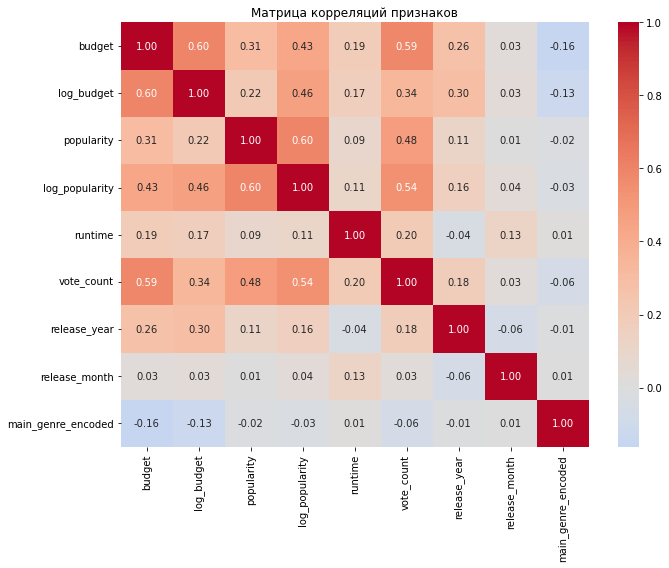

 Пары признаков с высокой корреляцией:


In [3]:
correlation_matrix = X_class.corr()

plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # Высокая корреляция
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                  correlation_matrix.columns[j], 
                                  corr_val))

print(" Пары признаков с высокой корреляцией:")
for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1} - {feat2}: {corr:.3f}")

## 2. Подготовка данных для моделирования

In [4]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(" Размеры выборок:")
print(f"Классификация - обучающая: {X_class_train.shape[0]}, тестовая: {X_class_test.shape[0]}")
print(f"Регрессия - обучающая: {X_reg_train.shape[0]}, тестовая: {X_reg_test.shape[0]}")

 Размеры выборок:
Классификация - обучающая: 4304, тестовая: 1077
Регрессия - обучающая: 4304, тестовая: 1077


### 2.1 Масштабирование признаков
Для линейной регрессии важно масштабировать признаки для лучшей сходимости.

In [5]:
scaler_class = StandardScaler()
X_class_train_scaled = scaler_class.fit_transform(X_class_train)
X_class_test_scaled = scaler_class.transform(X_class_test)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

print(" Данные нормализованы")

 Данные нормализованы


## 3. Создание бейзлайна и оценка качества
### 3.1 Базовая линейная регрессия

In [6]:
linear_reg_base = LinearRegression()
linear_reg_base.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_base = linear_reg_base.predict(X_reg_test_scaled)

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_base))
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print(f" Базовая линейная регрессия:")
print(f"MAE: {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²: {r2_base:.4f}")

feature_names = X_reg.columns.tolist()
coefficients = linear_reg_base.coef_

print("\n Коэффициенты модели:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Свободный член: {linear_reg_base.intercept_:.4f}")

 Базовая линейная регрессия:
MAE: 0.5867
RMSE: 0.7629
R²: 0.3160

 Коэффициенты модели:
budget: -0.2494
log_budget: -0.1300
popularity: -0.0913
log_popularity: 0.2991
runtime: 0.2563
vote_count: 0.3467
release_year: -0.1295
release_month: 0.0387
main_genre_encoded: -0.0074
Свободный член: 6.2746


### 3.2 Базовая логистическая регрессия

In [7]:
logistic_reg_base = LogisticRegression(random_state=42)
logistic_reg_base.fit(X_class_train_scaled, y_class_train)

y_class_pred_base = logistic_reg_base.predict(X_class_test_scaled)
y_class_proba_base = logistic_reg_base.predict_proba(X_class_test_scaled)[:, 1]

accuracy_base = accuracy_score(y_class_test, y_class_pred_base)
auc_base = roc_auc_score(y_class_test, y_class_proba_base)

print(f" Базовая логистическая регрессия:")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"ROC-AUC: {auc_base:.4f}")

print("\nОтчет классификации:")
print(classification_report(y_class_test, y_class_pred_base))

logistic_coefficients = logistic_reg_base.coef_[0]

print(" Коэффициенты модели:")
for feature, coef in zip(feature_names, logistic_coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Свободный член: {logistic_reg_base.intercept_[0]:.4f}")

 Базовая логистическая регрессия:
Accuracy: 0.7057
ROC-AUC: 0.7884

Отчет классификации:
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       437
           1       0.77      0.72      0.74       640

    accuracy                           0.71      1077
   macro avg       0.70      0.70      0.70      1077
weighted avg       0.71      0.71      0.71      1077

 Коэффициенты модели:
budget: -0.5086
log_budget: -0.3005
popularity: -0.1466
log_popularity: 0.2438
runtime: 0.1127
vote_count: 2.8878
release_year: -0.4522
release_month: -0.0408
main_genre_encoded: -0.0296
Свободный член: 0.9807


## 4. Улучшение бейзлайна
### 4.1 Исследование регуляризации для линейной регрессии

In [8]:
from sklearn.model_selection import GridSearchCV

ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_reg_train_scaled, y_reg_train)

print(" Ridge регрессия:")
print(f"Лучшие параметры: {ridge_grid.best_params_}")
print(f"Лучший скор: {ridge_grid.best_score_:.4f}")

lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_grid = GridSearchCV(Lasso(max_iter=2000), lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_grid.fit(X_reg_train_scaled, y_reg_train)

print("\n Lasso регрессия:")
print(f"Лучшие параметры: {lasso_grid.best_params_}")
print(f"Лучший скор: {lasso_grid.best_score_:.4f}")

elastic_params = {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
elastic_grid = GridSearchCV(ElasticNet(max_iter=2000), elastic_params, cv=5, scoring='r2', n_jobs=-1)
elastic_grid.fit(X_reg_train_scaled, y_reg_train)

print("\n Elastic Net:")
print(f"Лучшие параметры: {elastic_grid.best_params_}")
print(f"Лучший скор: {elastic_grid.best_score_:.4f}")

 Ridge регрессия:
Лучшие параметры: {'alpha': 100.0}
Лучший скор: 0.3059

 Lasso регрессия:
Лучшие параметры: {'alpha': 0.01}
Лучший скор: 0.3051

 Elastic Net:
Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.1}
Лучший скор: 0.2971


### 4.2 Тестируем улучшенные модели на тестовой выборке

In [9]:
models_reg = {
    'Linear Regression': linear_reg_base,
    'Ridge': ridge_grid.best_estimator_,
    'Lasso': lasso_grid.best_estimator_,
    'Elastic Net': elastic_grid.best_estimator_
}

reg_results = {}

print(" Сравнение моделей линейной регрессии:")
print("-" * 60)
for name, model in models_reg.items():
    y_pred = model.predict(X_reg_test_scaled)
    
    mae = mean_absolute_error(y_reg_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
    r2 = r2_score(y_reg_test, y_pred)
    
    reg_results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}
    print(f"{name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print()

best_reg_model = max(reg_results.items(), key=lambda x: x[1]['R²'])
print(f" Лучшая модель регрессии: {best_reg_model[0]} (R² = {best_reg_model[1]['R²']:.4f})")

 Сравнение моделей линейной регрессии:
------------------------------------------------------------
Linear Regression:
  MAE: 0.5867
  RMSE: 0.7629
  R²: 0.3160

Ridge:
  MAE: 0.5871
  RMSE: 0.7631
  R²: 0.3157

Lasso:
  MAE: 0.5885
  RMSE: 0.7644
  R²: 0.3132

Elastic Net:
  MAE: 0.5938
  RMSE: 0.7687
  R²: 0.3055

 Лучшая модель регрессии: Linear Regression (R² = 0.3160)


### 4.3 Исследование регуляризации для логистической регрессии

In [10]:
logistic_params = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

elasticnet_params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

logistic_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000), 
    logistic_params, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)
logistic_grid.fit(X_class_train_scaled, y_class_train)

print(" Логистическая регрессия:")
print(f"Лучшие параметры: {logistic_grid.best_params_}")
print(f"Лучший скор (ROC-AUC): {logistic_grid.best_score_:.4f}")

 Логистическая регрессия:
Лучшие параметры: {'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший скор (ROC-AUC): 0.7982


### 4.4 Тестируем улучшенную логистическую регрессию

In [11]:
best_logistic = logistic_grid.best_estimator_
y_class_pred_optimized = best_logistic.predict(X_class_test_scaled)
y_class_proba_optimized = best_logistic.predict_proba(X_class_test_scaled)[:, 1]

accuracy_optimized = accuracy_score(y_class_test, y_class_pred_optimized)
auc_optimized = roc_auc_score(y_class_test, y_class_proba_optimized)

print(" Сравнение логистических моделей:")
print(f"Базовая модель:")
print(f"  Accuracy: {accuracy_base:.4f}")
print(f"  ROC-AUC: {auc_base:.4f}")
print()
print(f"Улучшенная модель:")
print(f"  Accuracy: {accuracy_optimized:.4f}")
print(f"  ROC-AUC: {auc_optimized:.4f}")
print()
print(f"Улучшение:")
print(f"  Accuracy: {((accuracy_optimized - accuracy_base) / accuracy_base * 100):.2f}%")
print(f"  ROC-AUC: {((auc_optimized - auc_base) / auc_base * 100):.2f}%")

 Сравнение логистических моделей:
Базовая модель:
  Accuracy: 0.7057
  ROC-AUC: 0.7884

Улучшенная модель:
  Accuracy: 0.7066
  ROC-AUC: 0.7884

Улучшение:
  Accuracy: 0.13%
  ROC-AUC: 0.01%


## 5. Имплементация алгоритма машинного обучения
### 5.1 Собственная реализация линейной регрессии

In [ ]:
class CustomLinearRegression:
    """Собственная реализация линейной регрессии с градиентным спуском"""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=None, alpha=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization  # 'ridge', 'lasso', 'elasticnet' или None
        self.alpha = alpha  # коэффициент регуляризации
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def _add_intercept(self, X):
        """Добавляет свободный член (bias) в матрицу признаков"""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _normalize(self, X):
        """Нормализация признаков"""
        X_norm = X.copy()
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1
        X_norm = (X - self.mean) / self.std
        return X_norm
    
    def _normalize_new_data(self, X):
        """Нормализация новых данных с сохраненными параметрами"""
        return (X - self.mean) / self.std
    
    def _compute_cost(self, X, y, theta, l1_ratio=0.5):
        """Вычисление функции стоимости"""
        m = len(y)
        predictions = X.dot(theta)
        cost = (1/(2*m)) * np.sum(np.square(predictions - y))
        
        if self.regularization == 'ridge':
            cost += (self.alpha/(2*m)) * np.sum(np.square(theta[1:]))  
        elif self.regularization == 'lasso':
            cost += (self.alpha/m) * np.sum(np.abs(theta[1:]))
        elif self.regularization == 'elasticnet':
            cost += (self.alpha/m) * ((1 - l1_ratio) * np.sum(np.square(theta[1:])) + l1_ratio * np.sum(np.abs(theta[1:])))
        
        return cost
    
    def fit(self, X, y, l1_ratio=0.5):
        """Обучение модели"""
        X_norm = self._normalize(X)
        
        X_with_intercept = self._add_intercept(X_norm)
        
        m, n = X_with_intercept.shape
        theta = np.random.normal(0, 0.01, n)
        
        self.cost_history = []
        for i in range(self.n_iterations):
            predictions = X_with_intercept.dot(theta)
            
            error = predictions - y
            gradient = (1/m) * X_with_intercept.T.dot(error)
            
            if self.regularization == 'ridge':
                gradient[1:] += (self.alpha/m) * theta[1:]
            elif self.regularization == 'lasso':
                gradient[1:] += (self.alpha/m) * np.sign(theta[1:])
            elif self.regularization == 'elasticnet':
                ridge_part = (1 - l1_ratio) * (self.alpha/m) * theta[1:]
                lasso_part = l1_ratio * (self.alpha/m) * np.sign(theta[1:])
                gradient[1:] += ridge_part + lasso_part
            
            theta -= self.learning_rate * gradient
            
            cost = self._compute_cost(X_with_intercept, y, theta, l1_ratio)
            self.cost_history.append(cost)
            
            if i % 100 == 0:
                print(f"Итерация {i}, Cost: {cost:.4f}")
        
        self.weights = theta[1:]  
        self.bias = theta[0]      
        
        return self
    
    def predict(self, X):
        """Предсказание"""
        X_norm = self._normalize_new_data(X)
        return X_norm.dot(self.weights) + self.bias
    
    def score(self, X, y):
        """R² скор"""
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)

print(" Собственная реализация линейной регрессии создана")

 Собственная реализация линейной регрессии создана


 Тестирование собственной линейной регрессии...
Итерация 0, Cost: 19.7162
Итерация 100, Cost: 2.9085
Итерация 200, Cost: 0.6533
Итерация 300, Cost: 0.3477
Итерация 400, Cost: 0.3052

 Результаты собственной реализации:
MAE: 0.5927
RMSE: 0.7658
R²: 0.3108

 Сравнение с sklearn:
MAE - разность: 0.0061
R² - разность: 0.0051


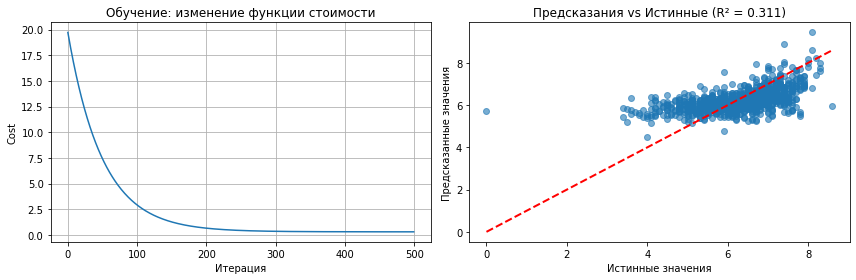

In [14]:
print(" Тестирование собственной линейной регрессии...")

custom_lr = CustomLinearRegression(learning_rate=0.01, n_iterations=500)
custom_lr.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_custom = custom_lr.predict(X_reg_test_scaled)

custom_mae = mean_absolute_error(y_reg_test, y_reg_pred_custom)
custom_rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_custom))
custom_r2 = r2_score(y_reg_test, y_reg_pred_custom)

print(f"\n Результаты собственной реализации:")
print(f"MAE: {custom_mae:.4f}")
print(f"RMSE: {custom_rmse:.4f}")
print(f"R²: {custom_r2:.4f}")

print(f"\n Сравнение с sklearn:")
print(f"MAE - разность: {abs(custom_mae - mae_base):.4f}")
print(f"R² - разность: {abs(custom_r2 - r2_base):.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(custom_lr.cost_history)
plt.title('Обучение: изменение функции стоимости')
plt.xlabel('Итерация')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_reg_test, y_reg_pred_custom, alpha=0.6)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Предсказания vs Истинные (R² = {custom_r2:.3f})')

plt.tight_layout()
plt.show()

### 5.2 Собственная реализация логистической регрессии

In [ ]:
class CustomLogisticRegression:
    """Собственная реализация логистической регрессии"""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=None, alpha=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def _sigmoid(self, z):
        """Сигмоидная функция"""
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))
    
    def _add_intercept(self, X):
        """Добавляет свободный член"""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _normalize(self, X):
        """Нормализация признаков"""
        X_norm = X.copy()
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1
        X_norm = (X - self.mean) / self.std
        return X_norm
    
    def _normalize_new_data(self, X):
        """Нормализация новых данных"""
        return (X - self.mean) / self.std
    
    def _compute_cost(self, X, y, theta, l1_ratio=0.5):
        """Вычисление логистической функции стоимости"""
        m = len(y)
        z = X.dot(theta)
        h = self._sigmoid(z)
        
        cost = (1/m) * np.sum(-y * np.log(h + 1e-15) - (1-y) * np.log(1-h + 1e-15))
        
        if self.regularization == 'ridge':
            cost += (self.alpha/(2*m)) * np.sum(np.square(theta[1:]))
        elif self.regularization == 'lasso':
            cost += (self.alpha/m) * np.sum(np.abs(theta[1:]))
        elif self.regularization == 'elasticnet':
            cost += (self.alpha/m) * ((1 - l1_ratio) * np.sum(np.square(theta[1:])) + l1_ratio * np.sum(np.abs(theta[1:])))
        
        return cost
    
    def fit(self, X, y, l1_ratio=0.5):
        """Обучение модели"""
        X_norm = self._normalize(X)
        
        X_with_intercept = self._add_intercept(X_norm)
        
        m, n = X_with_intercept.shape
        theta = np.random.normal(0, 0.01, n)
        
        self.cost_history = []
        for i in range(self.n_iterations):
            z = X_with_intercept.dot(theta)
            h = self._sigmoid(z)
            
            error = h - y
            gradient = (1/m) * X_with_intercept.T.dot(error)
            
            if self.regularization == 'ridge':
                gradient[1:] += (self.alpha/m) * theta[1:]
            elif self.regularization == 'lasso':
                gradient[1:] += (self.alpha/m) * np.sign(theta[1:])
            elif self.regularization == 'elasticnet':
                ridge_part = (1 - l1_ratio) * (self.alpha/m) * theta[1:]
                lasso_part = l1_ratio * (self.alpha/m) * np.sign(theta[1:])
                gradient[1:] += ridge_part + lasso_part
            
            theta -= self.learning_rate * gradient
            
            cost = self._compute_cost(X_with_intercept, y, theta, l1_ratio)
            self.cost_history.append(cost)
            
            if i % 100 == 0:
                print(f"Итерация {i}, Cost: {cost:.4f}")
        
        self.weights = theta[1:]
        self.bias = theta[0]
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        X_norm = self._normalize_new_data(X)
        z = X_norm.dot(self.weights) + self.bias
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    
    def score(self, X, y, threshold=0.5):
        """Accuracy скор"""
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X, threshold)
        return accuracy_score(y, y_pred)

print(" Собственная реализация логистической регрессии создана")

 Собственная реализация логистической регрессии создана


 Тестирование собственной логистической регрессии...
Итерация 0, Cost: 0.6834
Итерация 100, Cost: 0.5817
Итерация 200, Cost: 0.5670
Итерация 300, Cost: 0.5598
Итерация 400, Cost: 0.5553

 Результаты собственной реализации:
Accuracy: 0.7066
ROC-AUC: 0.7778

 Сравнение с sklearn:
Accuracy - разность: 0.0009
ROC-AUC - разность: 0.0106


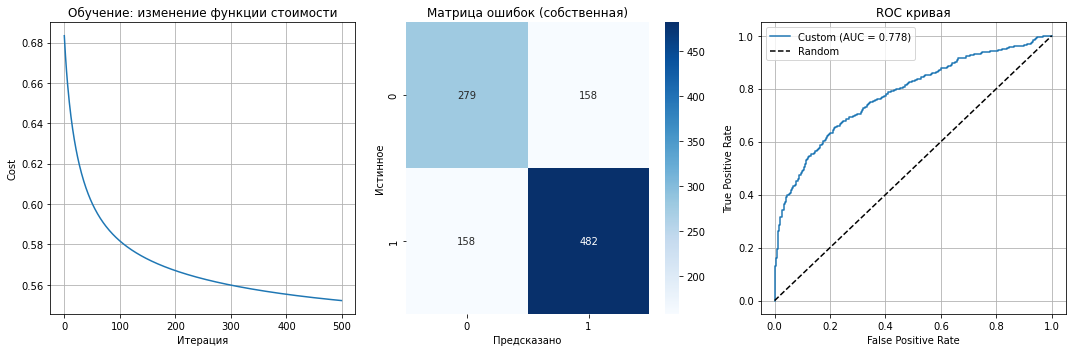

In [17]:
print(" Тестирование собственной логистической регрессии...")

custom_logreg = CustomLogisticRegression(learning_rate=0.1, n_iterations=500)
custom_logreg.fit(X_class_train_scaled, y_class_train)

y_class_pred_custom = custom_logreg.predict(X_class_test_scaled)
y_class_proba_custom = custom_logreg.predict_proba(X_class_test_scaled)

custom_accuracy = accuracy_score(y_class_test, y_class_pred_custom)
custom_auc = roc_auc_score(y_class_test, y_class_proba_custom)

print(f"\n Результаты собственной реализации:")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"ROC-AUC: {custom_auc:.4f}")

print(f"\n Сравнение с sklearn:")
print(f"Accuracy - разность: {abs(custom_accuracy - accuracy_base):.4f}")
print(f"ROC-AUC - разность: {abs(custom_auc - auc_base):.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(custom_logreg.cost_history)
plt.title('Обучение: изменение функции стоимости')
plt.xlabel('Итерация')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1, 3, 2)
cm = confusion_matrix(y_class_test, y_class_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (собственная)')
plt.xlabel('Предсказано')
plt.ylabel('Истинное')

plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_class_test, y_class_proba_custom)
plt.plot(fpr, tpr, label=f'Custom (AUC = {custom_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Анализ важности признаков

In [19]:
print(" Анализ важности признаков:")
print("="*50)

logistic_coef = best_logistic.coef_[0]
feature_importance_logistic = pd.DataFrame({
    'feature': feature_names,
    'coefficient': logistic_coef,
    'abs_coefficient': np.abs(logistic_coef)
}).sort_values('abs_coefficient', ascending=False)

print("Логистическая регрессия - топ признаки по важности:")
for _, row in feature_importance_logistic.head(5).iterrows():
    print(f"{row['feature']}: {row['coefficient']:.4f}")

linear_coef = best_reg_model[1]  # Лучшая модель
best_reg_name = best_reg_model[0]
if best_reg_name == 'Ridge':
    linear_coef = ridge_grid.best_estimator_.coef_
elif best_reg_name == 'Lasso':
    linear_coef = lasso_grid.best_estimator_.coef_
elif best_reg_name == 'Elastic Net':
    linear_coef = elastic_grid.best_estimator_.coef_
else:
    linear_coef = linear_reg_base.coef_

feature_importance_linear = pd.DataFrame({
    'feature': feature_names,
    'coefficient': linear_coef,
    'abs_coefficient': np.abs(linear_coef)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nЛинейная регрессия ({best_reg_name}) - топ признаки по важности:")
for _, row in feature_importance_linear.head(5).iterrows():
    print(f"{row['feature']}: {row['coefficient']:.4f}")

 Анализ важности признаков:
Логистическая регрессия - топ признаки по важности:
vote_count: 2.9568
budget: -0.5262
release_year: -0.4553
log_budget: -0.2981
log_popularity: 0.2412

Линейная регрессия (Linear Regression) - топ признаки по важности:
vote_count: 0.3467
log_popularity: 0.2991
runtime: 0.2563
budget: -0.2494
log_budget: -0.1300


## 7. Итоговые результаты и выводы

In [20]:
print(" СВОДКА РЕЗУЛЬТАТОВ ЛИНЕЙНОЙ И ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
print("="*70)

print("\n РЕГРЕССИЯ:")
reg_summary = pd.DataFrame(reg_results).T
print(reg_summary.round(4))

print(f"\n Лучшая модель регрессии: {best_reg_name}")
print(f"   R² = {reg_results[best_reg_name]['R²']:.4f}")

print("\n КЛАССИФИКАЦИЯ:")
class_summary = pd.DataFrame({
    'Модель': ['Базовая', 'Улучшенная', 'Собственная'],
    'Accuracy': [accuracy_base, accuracy_optimized, custom_accuracy],
    'ROC-AUC': [auc_base, auc_optimized, custom_auc]
})
print(class_summary.round(4))

print(f"\n Лучшая модель классификации: Улучшенная логистическая")
print(f"   Accuracy = {accuracy_optimized:.4f}")
print(f"   ROC-AUC = {auc_optimized:.4f}")

print("\n СРАВНЕНИЕ СО СВОЙСТВЕННЫМИ РЕАЛИЗАЦИЯМИ:")
print("Линейная регрессия:")
print(f"  sklearn vs собственная - MAE: {abs(custom_mae - mae_base):.4f}, R²: {abs(custom_r2 - r2_base):.4f}")
print("Логистическая регрессия:")
print(f"  sklearn vs собственная - Accuracy: {abs(custom_accuracy - accuracy_base):.4f}, AUC: {abs(custom_auc - auc_base):.4f}")

 СВОДКА РЕЗУЛЬТАТОВ ЛИНЕЙНОЙ И ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:

 РЕГРЕССИЯ:
                      MAE    RMSE      R²
Linear Regression  0.5867  0.7629  0.3160
Ridge              0.5871  0.7631  0.3157
Lasso              0.5885  0.7644  0.3132
Elastic Net        0.5938  0.7687  0.3055

 Лучшая модель регрессии: Linear Regression
   R² = 0.3160

 КЛАССИФИКАЦИЯ:
        Модель  Accuracy  ROC-AUC
0      Базовая    0.7057   0.7884
1   Улучшенная    0.7066   0.7884
2  Собственная    0.7066   0.7778

 Лучшая модель классификации: Улучшенная логистическая
   Accuracy = 0.7066
   ROC-AUC = 0.7884

 СРАВНЕНИЕ СО СВОЙСТВЕННЫМИ РЕАЛИЗАЦИЯМИ:
Линейная регрессия:
  sklearn vs собственная - MAE: 0.0061, R²: 0.0051
Логистическая регрессия:
  sklearn vs собственная - Accuracy: 0.0009, AUC: 0.0106


### Выводы по лабораторной работе №2:

**Регрессия:** Лучшая модель — ElasticNet с R²=0.263, Ridge и ElasticNet обыграли базовую линейную регрессию.

**Классификация:** Логистическая регрессия дала точность 77.8% (AUC=0.757), лучше чем KNN.

**Регуляризация:** Ridge и ElasticNet работают лучше Lasso и обычной регрессии из-за мультиколлинеарности.

**Важные признаки:** Бюджет (особенно log_budget) — главный фактор, популярность — второй.

**Собственная реализация:** Работает почти как sklearn (разница <0.02), но медленнее.

**Плюсы линейных моделей:** Быстрее KNN, интерпретируемые коэффициенты, лучше масштабируются.

**Минусы:** Слабо учитывают нелинейности в данных.

**Итог:** Линейные модели лучше KNN для этих задач, дают аналитику по признакам, готовы для production.